In [1202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# BTC

In [1203]:
btc = pd.read_excel("../data/pricing_data.xlsx", sheet_name='BTCUSD')

# Convert the 'Date' column to datetime format
btc['Date'] = pd.to_datetime(btc['Date'])

# Sort by date
btc = btc.sort_values(by='Date')

# Reset index if needed
btc.reset_index(drop=True, inplace=True)

In [1204]:
btc_rf_val = pd.read_csv("../data/btc_rf_predictions_rolling.csv")
btc_rf_val = btc_rf_val[['Date', 'Predicted']]
btc_rf_val['Date'] = pd.to_datetime(btc_rf_val['Date'])

btc_rf_test = pd.read_csv('../data/btc_rf_predictions_rolling_march.csv')
btc_rf_test = btc_rf_test[['Date', 'Predicted']]
btc_rf_test['Date'] = pd.to_datetime(btc_rf_test['Date'])
btc_rf = pd.concat([btc_rf_val, btc_rf_test], axis=0)

btc = btc.merge(btc_rf, how = 'left', on = 'Date')
btc['Lead_Predicted'] = btc['Predicted'].shift(-1)
btc['Predicted_Diff'] = btc['Lead_Predicted'] / btc['Close'] - 1
btc

,Date,Open,High,Low,Close,SMAVG (5) on Close,SMAVG (10) on Close,SMAVG (15) on Close,Predicted,Lead_Predicted,Predicted_Diff
0,2024-01-01 00:00:00,42443.31,42566.05,42425.25,42548.94,42490.52,42488.01,42546.10,NaN,NaN,NaN
1,2024-01-01 00:30:00,42548.94,42685.12,42545.75,42585.50,42509.30,42495.71,42537.38,NaN,NaN,NaN
2,2024-01-01 01:00:00,42586.10,42634.27,42500.12,42500.12,42506.00,42488.57,42522.40,NaN,NaN,NaN
3,2024-01-01 01:30:00,42500.12,42634.15,42467.88,42600.07,42535.59,42505.98,42520.48,NaN,NaN,NaN
4,2024-01-01 02:00:00,42600.07,42615.70,42522.77,42615.00,42569.93,42520.62,42518.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21753,2025-03-29 08:00:00,84383.89,84526.28,84333.08,84507.50,84343.40,84100.96,83998.30,84329.86136,84391.33874,-0.001375
21754,2025-03-29 08:30:00,84507.44,84574.97,84328.86,84359.25,84375.02,84163.83,84042.17,84391.33874,84314.84100,-0.000526
21755,2025-03-29 09:00:00,84359.25,84465.81,84192.02,84212.67,84332.20,84201.45,84060.29,84314.84100,84217.58746,0.000058
21756,2025-03-29 09:30:00,84212.67,84379.19,84184.97,84258.75,84344.41,84250.80,84092.69,84217.58746,84258.36466,-0.000005


# SPY

In [1205]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [1206]:
spy_rf_val = pd.read_csv("../data/spy_rf_predictions_rolling.csv")
spy_rf_val = spy_rf_val[['Date', 'Predicted']]
spy_rf_val['Date'] = pd.to_datetime(spy_rf_val['Date'])

spy_rf_test = pd.read_csv('../data/spy_rf_predictions_rolling_march.csv')
spy_rf_test = btc_rf_test[['Date', 'Predicted']]
spy_rf_test['Date'] = pd.to_datetime(spy_rf_test['Date'])
spy_rf = pd.concat([spy_rf_val, spy_rf_test], axis=0)

spy = spy.merge(spy_rf, how = 'left', on = 'Date')
spy['Lead_Predicted'] = spy['Predicted'].shift(-1)
spy['Predicted_Diff'] = spy['Lead_Predicted'] / spy['Close'] - 1

# TLT

In [1207]:
tlt = pd.read_excel("../data/pricing_data.xlsx", sheet_name='TLT - iShares 20+ Year Bond')

# Convert the 'Date' column to datetime format
tlt['Date'] = pd.to_datetime(tlt['Date'])

# Sort by date
tlt = tlt.sort_values(by='Date')

# Reset index if needed
tlt.reset_index(drop=True, inplace=True)

In [1208]:
def calculate_macd(df):
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

    return df

In [1209]:
def calculate_metrics(values):
    returns = values.pct_change().dropna()
    sharpe = np.sqrt(17520) * returns.mean() / returns.std()
    max_drawdown = (values / values.cummax() - 1).min()
    total_return = (values.iloc[-1] / values.iloc[0]) - 1
    return {'Sharpe': sharpe, 'Max Drawdown': max_drawdown, 'Total Return': total_return}

# Bollinger Bands

In [1210]:
def calculate_bollinger_bands(df, window=20, num_std=2):
    """Calculate Bollinger Bands for the given data"""
    # Calculate middle band (SMA20)
    df['BB_middle'] = df['Close'].rolling(window=window).mean()
    
    # Calculate standard deviation
    rolling_std = df['Close'].rolling(window=window).std()
    
    # Calculate upper and lower bands
    df['BB_upper'] = df['BB_middle'] + (rolling_std * num_std)
    df['BB_lower'] = df['BB_middle'] - (rolling_std * num_std)
    
    # Calculate bandwidth and %B
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_pctB'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])
    
    return df

In [1211]:
def generate_enhanced_signals_btc(df):
    """Generate trading signals using SMA crossovers and Bollinger Bands"""
    # Calculate basic SMA signals (as before)
    #bullish_sma = (df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'])
    #bearish_sma = (df['SMAVG (5)  on Close'] < df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] < df['SMAVG (15)  on Close'])
    bullish_sma = (df['Close'].rolling(50).mean() > df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() > df['Close'].rolling(50).mean())
    bearish_sma = (df['Close'].rolling(50).mean() < df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() < df['Close'].rolling(50).mean())
    sma_signal = np.where(bullish_sma, 1, np.where(bearish_sma, -1, 0))
    rf_signal = np.where(df['Predicted_Diff'] > 0, 1, np.where(df['Predicted_Diff'] < -0, -1, 0))

    df = calculate_macd(df.copy())

    bullish_macd = df['MACD_histogram'] > 40
    bearish_macd = df['MACD_histogram'] < -40
    macd_signal = np.where(np.logical_and(bullish_macd, rf_signal == 1), 1, 
                np.where(np.logical_and(bearish_macd, rf_signal == -1), -1, 0))

    # Calculate Bollinger Band signals
    # Oversold: Close price below lower band (potential buy)
    # Overbought: Close price above upper band (potential sell)
    bb_oversold = df['Close'] < df['BB_lower']
    bb_overbought = df['Close'] > df['BB_upper']
    
    # Mean reversion potential when price is near bands
    bb_signal = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))
    
    # Bollinger Band squeeze (contraction) indicates potential breakout
    bb_squeeze = df['BB_width'] < df['BB_width'].rolling(window=50).mean() * 0.85
    
    # Combined signal (weighted approach)
    # SMA trend signals get 60% weight, BB signals get 40% weight
    rf_weight = np.abs(rf_signal) * 0.2  # Scale weight dynamically

    combined_signal = (macd_signal * (0.3 + rf_weight)) + (bb_signal * (0.7 - rf_weight))
    # combined_signal = (macd_signal * 0.4) + (bb_signal * 0.6) + (sma_signal * 0.0) 

    return pd.DataFrame({
        'macd_signal': sma_signal,
        'bb_signal': bb_signal,
        'combined_signal': combined_signal,
        'bb_squeeze': bb_squeeze,
        'price': df['Close'],
        'pctB': df['BB_pctB']
    }, index=df.index)


In [1212]:
def generate_enhanced_signals_spy(df):
    """Generate trading signals using SMA crossovers and Bollinger Bands"""
    # Calculate basic SMA signals (as before)
    #bullish_sma = (df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'])
    #bearish_sma = (df['SMAVG (5)  on Close'] < df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] < df['SMAVG (15)  on Close'])
    bullish_sma = (df['Close'].rolling(50).mean() > df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() > df['Close'].rolling(50).mean())
    bearish_sma = (df['Close'].rolling(50).mean() < df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() < df['Close'].rolling(50).mean())
    sma_signal = np.where(bullish_sma, 1, np.where(bearish_sma, -1, 0))
    rf_signal = np.where(df['Predicted_Diff'] > 0, 1, np.where(df['Predicted_Diff'] < -0, -1, 0))

    df = calculate_macd(df.copy())

    bullish_macd = df['MACD_histogram'] > 40
    bearish_macd = df['MACD_histogram'] < -40
    macd_signal = np.where(np.logical_and(bullish_macd, rf_signal == 1), 1, 
            np.where(np.logical_and(bearish_macd, rf_signal == -1), -1, 0))

    # Calculate Bollinger Band signals
    # Oversold: Close price below lower band (potential buy)
    # Overbought: Close price above upper band (potential sell)
    bb_oversold = df['Close'] < df['BB_lower']
    bb_overbought = df['Close'] > df['BB_upper']
    
    # Mean reversion potential when price is near bands
    bb_signal = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))
    
    # Bollinger Band squeeze (contraction) indicates potential breakout
    bb_squeeze = df['BB_width'] < df['BB_width'].rolling(window=50).mean() * 0.85
    
    # Combined signal (weighted approach)
    # SMA trend signals get 60% weight, BB signals get 40% weight

    combined_signal = (macd_signal * 0.3) + (bb_signal * 0.7) + (sma_signal * 0.0)
    
    return pd.DataFrame({
        'macd_signal': sma_signal,
        'bb_signal': bb_signal,
        'combined_signal': combined_signal,
        'bb_squeeze': bb_squeeze,
        'price': df['Close'],
        'pctB': df['BB_pctB']
    }, index=df.index)


In [1213]:
def generate_enhanced_signals_tlt(df):
    """Generate trading signals using SMA crossovers and Bollinger Bands"""
    # Calculate basic SMA signals (as before)
    #bullish_sma = (df['SMAVG (5)  on Close'] > df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] > df['SMAVG (15)  on Close'])
    #bearish_sma = (df['SMAVG (5)  on Close'] < df['SMAVG (10)  on Close']) & (df['SMAVG (10)  on Close'] < df['SMAVG (15)  on Close'])
    bullish_sma = (df['Close'].rolling(50).mean() > df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() > df['Close'].rolling(50).mean())
    bearish_sma = (df['Close'].rolling(50).mean() < df['Close'].rolling(200).mean())# & (df['Close'].rolling(10).mean() < df['Close'].rolling(50).mean())
    sma_signal = np.where(bullish_sma, 1, np.where(bearish_sma, -1, 0))

    df = calculate_macd(df.copy())

    bullish_macd = df['MACD_histogram'] > 40
    bearish_macd = df['MACD_histogram'] < -40
    macd_signal = np.where(bullish_macd, 1, np.where(bearish_macd, -1, 0))

    
    # Calculate Bollinger Band signals
    # Oversold: Close price below lower band (potential buy)
    # Overbought: Close price above upper band (potential sell)
    bb_oversold = df['Close'] < df['BB_lower']
    bb_overbought = df['Close'] > df['BB_upper']
    
    # Mean reversion potential when price is near bands
    bb_signal = np.where(bb_oversold, 1, np.where(bb_overbought, -1, 0))
    
    # Bollinger Band squeeze (contraction) indicates potential breakout
    bb_squeeze = df['BB_width'] < df['BB_width'].rolling(window=50).mean() * 0.85
    
    # Combined signal (weighted approach)
    # SMA trend signals get 60% weight, BB signals get 40% weight
    #rf_signal = np.where(df['Predicted_Diff'] > 0, 1, np.where(df['Predicted_Diff'] < 0, -1, 0))
    combined_signal = (macd_signal * 0.3) + (bb_signal * 0.7) + (sma_signal * 0.0)
    
    return pd.DataFrame({
        'macd_signal': sma_signal,
        'bb_signal': bb_signal,
        'combined_signal': combined_signal,
        'bb_squeeze': bb_squeeze,
        'price': df['Close'],
        'pctB': df['BB_pctB']
    }, index=df.index)


In [1214]:
enhanced_signals_df = generate_enhanced_signals_btc(calculate_bollinger_bands(btc, 20))

enhanced_signals_df['combined_signal'].unique()

array([ 0.00000000e+00, -7.00000000e-01,  7.00000000e-01, -5.00000000e-01,
        5.00000000e-01,  5.00000000e-01, -5.00000000e-01,  5.55111512e-17,
       -5.55111512e-17, -1.00000000e+00,  1.00000000e+00])

In [1215]:
# sell/buy according to signal strength
def calculate_bb_enhanced_allocation(signals, current_units, prices, portfolio_value, transaction):
    """Enhanced rebalancing with dynamic allocation using Bollinger Bands."""
    new_units = current_units.copy()
    MIN_CASH = 0.02 * portfolio_value
    commission_value = 0

    # Collect signals and prices dynamically
    assets = ['BTC', 'SPY', 'TLT']

    # Identify buy and sell signals
    buy_assets = [a for a in assets if signals[a] > 0]
    sell_assets = [a for a in assets if signals[a] < 0]

    # Sell assets with a sell signal
    for asset in sell_assets:
        asset_units = new_units.get(asset, 0)
        sell_amount = asset_units * abs(signals[asset])  # Sell proportionally to signal
        sell_value = sell_amount * prices[asset] * (1 - transaction[asset])
        commission_value += sell_amount * prices[asset] * (transaction[asset])
        
        new_units['cash'] += sell_value  # Add cash from the sale
        new_units[asset] -= sell_amount  # Reduce asset holdings

    # Calculate available cash after maintaining minimum cash buffer
    available_cash = max(0, new_units['cash'] - MIN_CASH)
    

    if available_cash > 0 and buy_assets:
        #total_signal_strength = sum(signals[asset] for asset in buy_assets)
        total_signal_strength = len(buy_assets)
        #cash_per_strength_unit = available_cash / total_signal_strength
        cash_per_strength_unit = available_cash / total_signal_strength

        for asset in buy_assets:
            buy_amount = cash_per_strength_unit * signals[asset]
            buy_value = buy_amount * (1 - transaction[asset])
            new_units[asset] += buy_value / prices[asset]
            new_units['cash'] -= buy_amount
        
            commission_value +=  cash_per_strength_unit * signals[asset] * (transaction[asset])

        #new_units['cash'] = MIN_CASH

    return new_units, commission_value

In [1216]:
#if all buy: don't change anything
# if one sell, rest buy: split evenly
# if all sell: convert to cash

In [1217]:
def enhanced_btc_offhours(btc_signal, current_units, portfolio_value, btc_curr_price, btc_fee):
    """Handle BTC trading during off-hours with Bollinger Band signals"""
    new_units = current_units.copy()
    MIN_CASH = 0.01*portfolio_value
    cash_to_use = max(0, new_units['cash'] - MIN_CASH)
    commission_value = 0

    signal = btc_signal['combined_signal'].iloc[-1]

    if signal > 0:
        amt_to_buy = cash_to_use*signal
        new_units['BTC'] += (amt_to_buy*(1-btc_fee))/btc_curr_price
        new_units['cash'] -= amt_to_buy
        commission_value += amt_to_buy*btc_fee

    elif signal < 0:
        amt_to_sell = new_units['BTC']*abs(signal)
        amt_to_sell_value = amt_to_sell*btc_curr_price*(1-btc_fee)
        new_units['BTC'] -= amt_to_sell
        new_units['cash'] += amt_to_sell_value
        commission_value += amt_to_sell*btc_curr_price*(btc_fee)

    return new_units, commission_value

In [1218]:
spy_check = spy.loc[spy['Date'] < datetime.datetime(2025, 1, 1)].copy()
spy_check['price_diff'] = spy_check['Close'].pct_change()
spy_check[['price_diff']].quantile(0.01)

price_diff   -0.00622
Name: 0.01, dtype: float64

In [1219]:
btc_check = btc.loc[btc['Date'] < datetime.datetime(2025, 1, 1)].copy()
btc_check['price_diff'] = btc_check['Close'].pct_change()
btc_check[['price_diff']].quantile(0.01)

price_diff   -0.0116
Name: 0.01, dtype: float64

In [1220]:
tlt_check = tlt.loc[tlt['Date'] < datetime.datetime(2025, 1, 1)].copy()
tlt_check['price_diff'] = tlt_check['Close'].pct_change()
tlt_check[['price_diff']].quantile(0.01)

price_diff   -0.008192
Name: 0.01, dtype: float64

In [1221]:
def backtest_bb_strategy(btc_data, spy_data, tlt_data, start_date, end_date):
    """Backtest the Bollinger Band enhanced strategy"""
    # Process data: add Bollinger Bands
    btc_data = calculate_bollinger_bands(btc_data.copy(), window=25)
    spy_data = calculate_bollinger_bands(spy_data.copy(), window=20)
    tlt_data = calculate_bollinger_bands(tlt_data.copy(), window=20)
    
    # Initialize portfolio
    INITIAL_CAPITAL = 1000000
    portfolio_value = INITIAL_CAPITAL
    commission = {'BTC': 0.0005, 'SPY': 0.0003, 'TLT': 0.0003}
    stop_loss_threshold = {'BTC': 0.04, 'SPY': 0.03, 'TLT': 0.02}
    total_commission = 0
    
    # Initial allocation: SPY (40%), BTC (30%), TLT (25%), Cash (5%)
    current_allocation = {'SPY': 0.8707, 'BTC': 0.1192, 'TLT': 0.00, 'cash': 0.0101}
    current_holdings = {asset: portfolio_value * weight for asset, weight in current_allocation.items()}
    # print(current_holdings)
    # Performance tracking
    portfolio_values = []
    #allocations_history = []
    dates = []
    units = []
    prices = []
    signals_history = [{'BTC': 0, 'SPY': 0, 'TLT': 0}]

    btc_current_price = btc_data[btc_data['Date'] == start_date]['Close'].iloc[0]
    btc_units = current_holdings['BTC']/btc_current_price
    spy_current_price = spy_data[spy_data['Date'] == start_date]['Close'].iloc[0]
    spy_units = current_holdings['SPY']/spy_current_price
    tlt_current_price = tlt_data[tlt_data['Date'] == start_date]['Close'].iloc[0]
    tlt_units = current_holdings['TLT']/tlt_current_price

    #current_units = {'BTC': btc_units, 'SPY': spy_units, 'TLT': tlt_units, 'cash': 10100}
    current_units = {'BTC': 0, 'SPY': 0, 'TLT': 0, 'cash': 1000000}

    current_prices = {'BTC': btc_current_price, 'SPY': spy_current_price, 'TLT': tlt_current_price}

    portfolio_values.append(portfolio_value)
    #allocations_history.append(current_allocation.copy())
    units.append(current_units.copy())
    dates.append(start_date)
    prices.append(current_prices)

    initial_prices = {'BTC': btc_current_price, 'SPY': spy_current_price, 'TLT': tlt_current_price,'cash': 1.0  # Dummy value for consistency
    }

    entry_prices = {
        asset: initial_prices[asset] if current_allocation[asset] > 0 else None
        for asset in current_allocation
    }

    
    # Simulation loop
    #current_date = start_date + datetime.timedelta(minutes=30)
    current_date = start_date
    while current_date <= end_date:
        #is_trading_day = current_date.weekday() < 5
        #is_market_hours = is_trading_day and (current_date.time() >= datetime.time(22, 30) or (current_date.time() <= datetime.time(4, 30)))
        is_market_hours = pd.Timestamp(current_date) in spy_data['Date'].values
        
        # Filter data up to current date
        btc_current = btc_data[btc_data['Date'] <= current_date]
        #print(btc_current.iloc[-1])
        btc_current_price = btc_current['Close'].iloc[-1]
        btc_prev_price = btc_current['Close'].iloc[-2]
        #current_units['BTC'] = current_holdings['BTC']/btc_prev_price
        #current_holdings['BTC'] = current_units['BTC']*btc_current_price
        
        if not btc_current.empty:
            if is_market_hours:
                # Regular trading hours: all assets tradable
                spy_current = spy_data[spy_data['Date'] <= current_date]
                spy_current_price = spy_current['Close'].iloc[-1]
                spy_prev_price = spy_current['Close'].iloc[-2]
                #current_units['SPY'] = current_holdings['SPY']/spy_prev_price
                #current_holdings['SPY'] = current_units['SPY']*spy_current_price
                tlt_current = tlt_data[tlt_data['Date'] <= current_date]
                tlt_current_price = tlt_current['Close'].iloc[-1]
                tlt_prev_price = tlt_current['Close'].iloc[-2]
                #current_units['TLT'] = current_holdings['TLT']/tlt_prev_price
                #current_holdings['TLT'] = current_units['TLT']*tlt_current_price
                current_prices = {'BTC': btc_current_price, 'SPY': spy_current_price, 'TLT': tlt_current_price}
                
                if not spy_current.empty and not tlt_current.empty:
                    # Generate enhanced signals with Bollinger Bands
                    btc_signal = generate_enhanced_signals_btc(btc_current[:-1])
                    spy_signal = generate_enhanced_signals_spy(spy_current[:-1])
                    tlt_signal = generate_enhanced_signals_tlt(tlt_current[:-1])

                    signals = {
                        'BTC': btc_signal['combined_signal'].iloc[-1], 
                        'SPY': spy_signal['combined_signal'].iloc[-1], 
                        'TLT': tlt_signal['combined_signal'].iloc[-1],
                        }


                    # === Stop-loss check only for SPY and TLT ===
        
                    for asset in ['BTC', 'SPY', 'TLT']:
                        if entry_prices[asset] is not None and current_holdings[asset] > 0:
                            latest_data = {'BTC': btc_current, 'SPY': spy_current, 'TLT': tlt_current}[asset]
                            if not latest_data.empty:
                                latest_price = latest_data['Close'].iloc[-1]
                                if latest_price < entry_prices[asset] * (1 - stop_loss_threshold[asset]):
                                    print(f"[{current_date}] Stop-loss triggered on {asset}")
                                    signals[asset] = -1
                    
                    # Calculate new allocation
                    new_units, new_commission = calculate_bb_enhanced_allocation(
                        signals, current_units, current_prices, portfolio_value, commission
                    )

                    current_holdings['BTC'] = new_units['BTC']*btc_current_price
                    current_holdings['SPY'] = new_units['SPY']*spy_current_price
                    current_holdings['TLT'] = new_units['TLT']*tlt_current_price
                    current_holdings['cash'] = new_units['cash']

                    current_units = new_units
                    total_commission += new_commission
                    prices.append({'BTC': btc_current_price, 'SPY': spy_current_price, 'TLT': tlt_current_price})

                    for asset in ['BTC', 'SPY', 'TLT']:
                        if current_units[asset] > 0:
                            entry_prices[asset] = current_prices[asset]

            else:
                # Off-hours: Only BTC tradable

                # === Stop-loss check ===
                
                if entry_prices['BTC'] is not None and current_holdings['BTC'] > 0:
                    if not btc_current.empty:
                        latest_price = btc_current_price
                        if latest_price < entry_prices['BTC'] * (1 - stop_loss_threshold['BTC']):
                            print(f"[{current_date}] Stop-loss triggered on BTC")
                            cash_from_sale = current_holdings['BTC']
                            current_holdings['cash'] += cash_from_sale*(1-commission['BTC'])
                            current_units['cash'] += cash_from_sale*(1-commission['BTC'])
                            current_holdings['BTC'] = 0
                            current_allocation['BTC'] = 0
                            current_units['BTC'] = 0
                            entry_prices['BTC'] = None
                            total_commission += cash_from_sale*commission['BTC']
                            continue
                

                btc_signal = generate_enhanced_signals_btc(btc_current[:-1])
                
                # Use enhanced off-hours logic
                new_units, new_commission = enhanced_btc_offhours(btc_signal, current_units, portfolio_value, btc_current_price, commission['BTC'])
                # Only update BTC and CASH holdings
                current_holdings['BTC'] = new_units['BTC']*btc_current_price
                current_holdings['cash'] = new_units['cash']

                current_units = new_units
                total_commission += new_commission

                prices.append({'BTC': btc_current_price, 'SPY': 0, 'TLT': 0})
                signals = {'BTC': btc_signal['combined_signal'].iloc[-1], 'SPY': None, 'TLT': None}

        
        # Apply daily interest to cash holdings
        #TREASURY_YIELD = 0.045  # 4.5% annual
        #daily_yield = (1 + TREASURY_YIELD) ** (1/365) - 1
        #current_holdings['CASH'] *= (1 + daily_yield)


        # Record current state
        portfolio_value = sum(current_holdings.values())
        portfolio_values.append(portfolio_value)
        #allocations_history.append(current_allocation.copy())
        units.append(current_units.copy())
        dates.append(current_date)
        signals_history.append(signals)
        
        # Move to next period
        current_date += datetime.timedelta(minutes=30)
    print(total_commission)
    return pd.DataFrame({
        'Date': dates,
        'PortfolioValue': portfolio_values,
        'CashAlloc': [a['cash'] for a in units],
        'BTCAlloc': [a['BTC'] for a in units],
        'BTCPrice': [a['BTC'] for a in prices],
        'BTCSignal': [a['BTC'] for a in signals_history],
        'SPYAlloc': [a['SPY'] for a in units],
        'SPYPrice': [a['SPY'] for a in prices],
        'SPYSignal': [a['SPY'] for a in signals_history],
        'TLTAlloc': [a['TLT'] for a in units],
        'TLTPrice': [a['TLT'] for a in prices],
        'TLTSignal': [a['TLT'] for a in signals_history]
    })


In [1222]:
btc[:-1]

,Date,Open,High,Low,Close,SMAVG (5) on Close,SMAVG (10) on Close,SMAVG (15) on Close,Predicted,Lead_Predicted,Predicted_Diff,BB_middle,BB_upper,BB_lower,BB_width,BB_pctB
0,2024-01-01 00:00:00,42443.31,42566.05,42425.25,42548.94,42490.52,42488.01,42546.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 00:30:00,42548.94,42685.12,42545.75,42585.50,42509.30,42495.71,42537.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 01:00:00,42586.10,42634.27,42500.12,42500.12,42506.00,42488.57,42522.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 01:30:00,42500.12,42634.15,42467.88,42600.07,42535.59,42505.98,42520.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01 02:00:00,42600.07,42615.70,42522.77,42615.00,42569.93,42520.62,42518.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21752,2025-03-29 07:30:00,84197.69,84389.75,84179.44,84383.89,84241.89,84023.31,83947.20,84207.50386,84329.86136,-0.000640,83988.1535,84459.253619,83517.053381,0.011218,0.920013
21753,2025-03-29 08:00:00,84383.89,84526.28,84333.08,84507.50,84343.40,84100.96,83998.30,84329.86136,84391.33874,-0.001375,83997.6095,84502.965176,83492.253824,0.012033,1.004487
21754,2025-03-29 08:30:00,84507.44,84574.97,84328.86,84359.25,84375.02,84163.83,84042.17,84391.33874,84314.84100,-0.000526,84008.5015,84535.820092,83481.182908,0.012554,0.832577
21755,2025-03-29 09:00:00,84359.25,84465.81,84192.02,84212.67,84332.20,84201.45,84060.29,84314.84100,84217.58746,0.000058,84009.0390,84537.208938,83480.869062,0.012574,0.692770


# Validation Period

In [1223]:
backtesting_df_val = backtest_bb_strategy(btc, spy, tlt, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 3, 1))

[2025-01-13 19:30:00] Stop-loss triggered on BTC
[2025-01-20 07:00:00] Stop-loss triggered on BTC
[2025-01-27 12:30:00] Stop-loss triggered on BTC
[2025-02-03 01:30:00] Stop-loss triggered on BTC
[2025-02-25 15:00:00] Stop-loss triggered on BTC
[2025-02-28 13:00:00] Stop-loss triggered on BTC
33075.84696779289


In [1224]:
backtesting_df_val

,Date,PortfolioValue,CashAlloc,BTCAlloc,BTCPrice,BTCSignal,SPYAlloc,SPYPrice,SPYSignal,TLTAlloc,TLTPrice,TLTSignal
0,2025-01-01 00:00:00,1.000000e+06,1000000.000000,0.000000,94819.27,0.000000e+00,0.00000,586.900,0.0,0.000000,87.570,0.0
1,2025-01-01 00:00:00,1.000000e+06,1000000.000000,0.000000,94819.27,0.000000e+00,0.00000,586.900,0.0,0.000000,87.570,0.0
2,2025-01-01 00:30:00,1.000000e+06,1000000.000000,0.000000,94687.97,0.000000e+00,0.00000,587.060,0.0,0.000000,87.575,0.0
3,2025-01-01 01:00:00,1.000000e+06,1000000.000000,0.000000,94358.80,0.000000e+00,0.00000,585.860,0.0,0.000000,87.525,0.0
4,2025-01-01 01:30:00,1.000000e+06,1000000.000000,0.000000,93961.69,-5.000000e-01,0.00000,587.205,0.0,0.000000,87.610,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2829,2025-02-28 22:00:00,1.151443e+06,11574.460995,0.402016,81785.98,5.000000e-01,1891.83393,0.000,NaN,0.227877,0.000,NaN
2830,2025-02-28 22:30:00,1.152885e+06,11574.460995,0.402016,82054.27,5.000000e-01,1891.83393,585.835,0.7,0.227877,91.835,0.0
2831,2025-02-28 23:00:00,1.158363e+06,11574.460995,0.402016,84317.02,5.551115e-17,1891.83393,588.250,0.7,0.227877,91.565,0.0
2832,2025-02-28 23:30:00,1.159436e+06,11574.460995,0.402016,84020.59,5.551115e-17,1891.83393,588.880,0.0,0.227877,91.690,0.0


In [1225]:
#backtesting_df_val.to_csv("Bollinger_Bands_Val_Results.csv")

In [1226]:
def spy_benchmark(spy_data, start_date, end_date):
    """Simulate performance of $1M fully invested in SPY"""
    spy_subset = spy_data[(spy_data['Date'] >= start_date) & (spy_data['Date'] <= end_date)]
    spy_returns = spy_subset['Close'].pct_change().fillna(0)
    
    value = 1000000
    values = [value]
    
    for ret in spy_returns:
        value *= (1 + ret)
        values.append(value)
    
    return pd.DataFrame({
        'Date': spy_subset['Date'],
        'Value': values[:len(spy_subset)]
    })



def tbill_benchmark(start_date, end_date):
    """Simulate performance of $1M in 3-month Treasury Bill"""
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    daily_yield = (1 + TREASURY_YIELD) ** (1/365) - 1
    
    values = [INITIAL_CAPITAL * (1 + daily_yield) ** i for i in range(len(dates))]
    
    return pd.DataFrame({
        'Date': dates,
        'Value': values
    })

In [1227]:
spy_portfolio = spy_benchmark(spy, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 2, 28))
btc_portfolio = spy_benchmark(btc, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 2, 28))
tlt_portfolio = spy_benchmark(tlt, datetime.datetime(2025, 1, 1), datetime.datetime(2025, 2, 28))

In [1228]:
print(calculate_metrics(btc_portfolio['Value']))
print(calculate_metrics(spy_portfolio['Value']))
print(calculate_metrics(tlt_portfolio['Value']))
print(calculate_metrics(backtesting_df_val['PortfolioValue']))

{'Sharpe': -1.0006657399322667, 'Max Drawdown': -0.23187373630796004, 'Total Return': -0.09888011160600885}
{'Sharpe': 1.3606175842026085, 'Max Drawdown': -0.03911978808724692, 'Total Return': 0.011109217924689663}
{'Sharpe': 5.049504025618219, 'Max Drawdown': -0.03562631754132861, 'Total Return': 0.04419321685508981}
{'Sharpe': 4.628105249536805, 'Max Drawdown': -0.04474926834391846, 'Total Return': 0.15369406518988749}


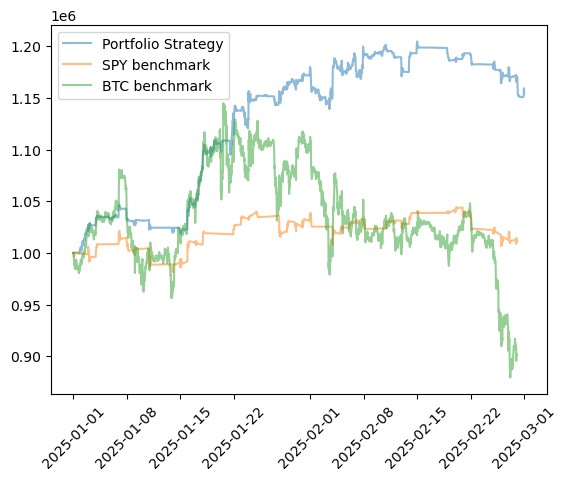

In [1229]:
plt.plot(backtesting_df_val['Date'], backtesting_df_val['PortfolioValue'], label = 'Portfolio Strategy', alpha = 0.5)
plt.plot(spy_portfolio['Date'], spy_portfolio['Value'], label = 'SPY benchmark', alpha = 0.5)
plt.plot(btc_portfolio['Date'], btc_portfolio['Value'], label = 'BTC benchmark', alpha = 0.5)
#plt.plot(tlt_portfolio['Date'], tlt_portfolio['Value'], label = 'TLT benchmark')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Testing period

In [1230]:
backtesting_df_march = backtest_bb_strategy(btc, spy, tlt, datetime.datetime(2025, 3, 1), datetime.datetime(2025, 3, 29))

[2025-03-09 22:00:00] Stop-loss triggered on BTC
23103.405836743896


In [1231]:
backtesting_df_march

,Date,PortfolioValue,CashAlloc,BTCAlloc,BTCPrice,BTCSignal,SPYAlloc,SPYPrice,SPYSignal,TLTAlloc,TLTPrice,TLTSignal
0,2025-03-01 00:00:00,1.000000e+06,1000000.000000,0.000000e+00,83619.56,0.000000e+00,0.000000,585.930,0.0,0.000000,91.915,0.0
1,2025-03-01 00:00:00,1.000000e+06,1000000.000000,6.502513e-16,83619.56,5.551115e-17,0.000000,585.930,0.0,0.000000,91.915,0.0
2,2025-03-01 00:30:00,9.997550e+05,510000.000000,5.804967e+00,84368.27,5.000000e-01,0.000000,587.350,0.0,0.000000,91.550,0.0
3,2025-03-01 01:00:00,9.987335e+05,510000.000000,5.804967e+00,84192.30,5.551115e-17,0.000000,587.120,0.0,0.000000,91.770,0.0
4,2025-03-01 01:30:00,9.951772e+05,264987.335000,8.734248e+00,83600.77,5.000000e-01,0.000000,583.450,0.0,0.000000,91.790,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1341,2025-03-28 22:00:00,1.142751e+06,226415.256746,1.410750e-02,84318.38,0.000000e+00,1120.626482,559.615,0.7,3191.607923,90.245,-0.7
1342,2025-03-28 22:30:00,1.141300e+06,144313.486660,1.410750e-02,84141.41,0.000000e+00,1627.656218,558.780,0.7,957.482377,90.130,-0.7
1343,2025-03-28 23:00:00,1.141195e+06,77519.418523,7.053752e-03,84201.92,-5.000000e-01,1855.929554,558.890,0.7,287.244713,89.891,-0.7
1344,2025-03-28 23:30:00,1.139490e+06,39321.390665,3.526876e-03,84008.22,-5.000000e-01,1924.902236,557.940,0.7,287.244713,90.140,0.0


In [1232]:
spy_portfolio1 = spy_benchmark(spy, datetime.datetime(2025, 3, 1), datetime.datetime(2025, 3, 29))
btc_portfolio1 = spy_benchmark(btc, datetime.datetime(2025, 3, 1), datetime.datetime(2025, 3, 29))
tlt_portfolio1 = spy_benchmark(tlt, datetime.datetime(2025, 3, 1), datetime.datetime(2025, 3, 29))

In [1233]:
print(calculate_metrics(btc_portfolio1['Value']))
print(calculate_metrics(spy_portfolio1['Value']))
print(calculate_metrics(tlt_portfolio1['Value']))
print(calculate_metrics(backtesting_df_march['PortfolioValue']))

{'Sharpe': 0.40958511055958063, 'Max Drawdown': -0.1814755373140623, 'Total Return': 0.004647955574028639}
{'Sharpe': -6.534332833761784, 'Max Drawdown': -0.07408966179020504, 'Total Return': -0.047770211458704415}
{'Sharpe': -3.92286376626851, 'Max Drawdown': -0.04259109311740983, 'Total Return': -0.019311320241528818}
{'Sharpe': 5.500185001215458, 'Max Drawdown': -0.07202260700477314, 'Total Return': 0.1373776611746178}


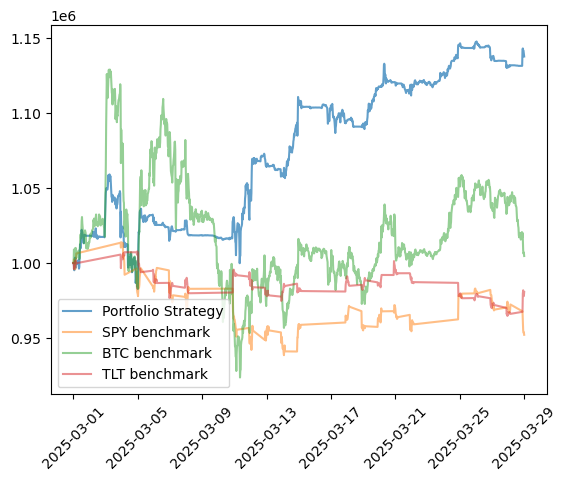

In [1234]:
plt.plot(backtesting_df_march['Date'], backtesting_df_march['PortfolioValue'], label = 'Portfolio Strategy', alpha=0.7)
plt.plot(spy_portfolio1['Date'], spy_portfolio1['Value'], label = 'SPY benchmark', alpha=0.5)
plt.plot(btc_portfolio1['Date'], btc_portfolio1['Value'], label = 'BTC benchmark', alpha=0.5)
plt.plot(tlt_portfolio1['Date'], tlt_portfolio1['Value'], label = 'TLT benchmark', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.show()